In [1]:
import os
from glob import glob
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import losses, models, layers, optimizers, callbacks, utils, metrics
from tensorflow.keras.applications import EfficientNetB1

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

데이터

In [2]:
def resize_images(img_path):
    images=glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")
    
image_dir_path = "data/train/scissors/"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

100  images to be resized.
100  images resized.
가위 이미지 resize 완료!


In [3]:
for i in ["train","train2","train3","test"]:
    for j in ["rock","paper","scissors"]:
        image_dir_path = f"data/{i}/{j}/"
        resize_images(image_dir_path)

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
110  images to be resized.
110  images resized.
110  images to be resized.
110  images resized.
110  images to be resized.
110  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


In [3]:
train_rock = glob("data/train/rock/*")[:100]+glob("data/train2/rock/*")[:100]+glob("data/train3/rock/*")[:100]
train_paper = glob("data/train/paper/*")[:100]+glob("data/train2/paper/*")[:100]+glob("data/train3/paper/*")[:100]
train_scissors = glob("data/train/scissors/*")[:100]+glob("data/train2/scissors/*")[:100]+glob("data/train3/scissors/*")[:100]

train_all = train_rock+train_paper+train_scissors
train_target = ["rock"]*300+["paper"]*300+["scissors"]*300

print(len(train_rock),len(train_paper),len(train_scissors), len(train_all), len(train_target))

300 300 300 900 900


In [4]:
train_df = pd.DataFrame(columns=["path","target"])
train_df["path"]=train_all
train_df["target"]=train_target

In [5]:
train_df

,path,target
0,data/train/rock/0.jpg,rock
1,data/train/rock/1.jpg,rock
2,data/train/rock/10.jpg,rock
3,data/train/rock/11.jpg,rock
4,data/train/rock/12.jpg,rock
...,...,...
895,data/train3/scissors/95.jpg,scissors
896,data/train3/scissors/96.jpg,scissors
897,data/train3/scissors/97.jpg,scissors
898,data/train3/scissors/98.jpg,scissors


모델

In [6]:
def build_eff_model():
    x = layers.Input(shape=(32, 32, 3)) 
    y = EfficientNetB1(input_shape=(32,32,3), include_top=False, weights='imagenet')(x)
    y = layers.GlobalAveragePooling2D(name="avg_pool")(y)
    y = layers.BatchNormalization()(y)
    y = layers.Dense(32,activation=tf.keras.layers.LeakyReLU(),name="Dense_last")(y)
    y = layers.BatchNormalization()(y)
    y = layers.Dense(3, activation="softmax", name="Pred")(y)
    model = models.Model(x, y, name="EfficientNet_b1")
    optimizer = optimizers.Adam(learning_rate=0.0002)
    loss = losses.SparseCategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=["acc"])
    return model

simple_aug = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        layers.RandomBrightness(0.2),
        layers.RandomContrast(0.2)
    ]
)

def process_path(file_path, target):
    
    def get_label(target):
        one_hot = target == class_names  # True / False
        return tf.argmax(one_hot)

    label = get_label(target)
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [32, 32])
    img = img / 255  
    return img, label

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [7]:
from IPython.display import clear_output
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

class PlotLearning(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []   
    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]     
        metrics = [x for x in logs if 'val' not in x]
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)
        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)      
            axs[i].legend()
        plt.tight_layout()
        plt.show()

훈련

In [8]:
# DS
list_ds = tf.data.Dataset.from_tensor_slices( (train_df["path"].values, train_df["target"].values) )
list_ds = list_ds.shuffle(len(list_ds), reshuffle_each_iteration=False)
class_names = np.array( train_df["target"].unique() )

# DS split (15%)
val_size = int(len(list_ds)*0.15)
train_ = list_ds.skip(val_size)
valid_ = list_ds.take(val_size)
NUM_TRAIN = tf.data.experimental.cardinality(train_).numpy()
NUM_VALID = tf.data.experimental.cardinality(valid_).numpy()

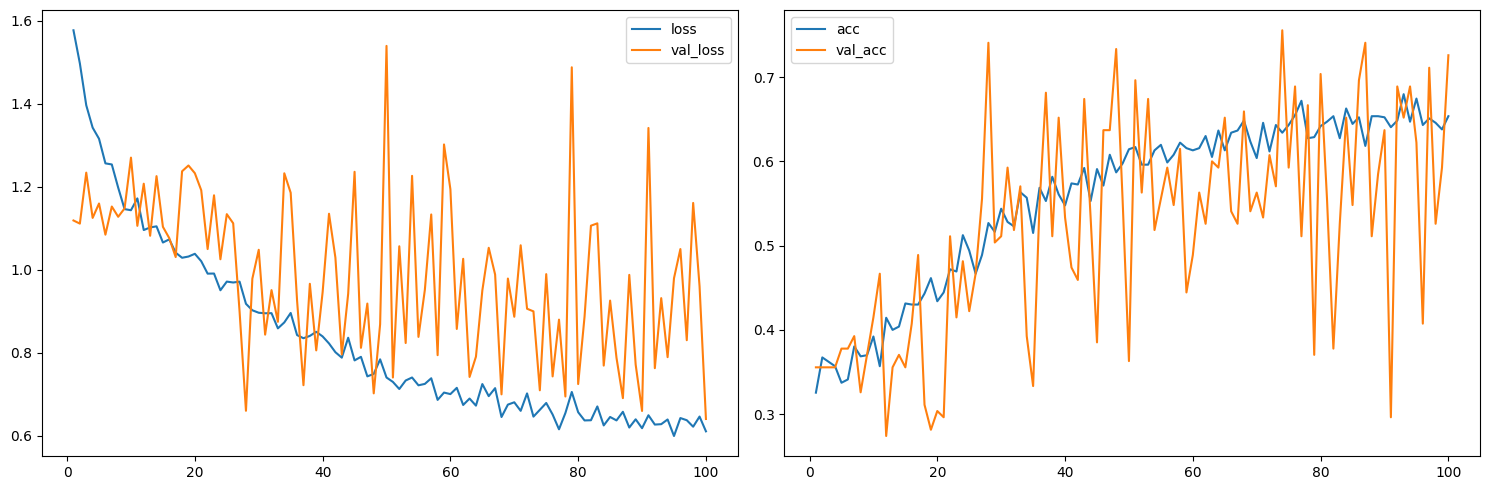

48/48 [==============================] - 4s 86ms/step - loss: 0.6112 - acc: 0.6536 - val_loss: 0.6409 - val_acc: 0.7259


In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 16

# 전처리
train_ds = train_.map(process_path, num_parallel_calls=AUTOTUNE)
valid_ds = valid_.map(process_path, num_parallel_calls=AUTOTUNE)
# 증강
train_ds = train_ds.map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTOTUNE)
# 성능향상
train_ds = configure_for_performance(train_ds) 
valid_ds = configure_for_performance(valid_ds)
# 모델
model = build_eff_model()
# callback
# ckp = callbacks.ModelCheckpoint(f"RPS.h5", save_best_only=True,  monitor="val_acc")
# 학습
history = model.fit(train_ds, epochs=100, validation_data=valid_ds, callbacks=[PlotLearning()])